In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from dike_model_function import DikeNetwork  # @UnresolvedImport


def sum_over(*args):
    return sum(args)

In [6]:
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation


ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(3)

In [7]:
for unc in dike_model.uncertainties:
    print(repr(unc))
    
uncertainties = dike_model.uncertainties

import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132)
RealParameter('A.1_Bmax', 30, 350)
RealParameter('A.1_pfail', 0, 1)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350)
RealParameter('A.2_pfail', 0, 1)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350)
RealParameter('A.3_pfail', 0, 1)
CategoricalParameter('A.3_Brate', [0, 1, 2])
RealParameter('A.4_Bmax', 30, 350)
RealParameter('A.4_pfail', 0, 1)
CategoricalParameter('A.4_Brate', [0, 1, 2])
RealParameter('A.5_Bmax', 30, 350)
RealParameter('A.5_pfail', 0, 1)
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [8]:
for policy in dike_model.levers:
    print(repr(policy))
    
levers = dike_model.levers 

import copy
levers = copy.deepcopy(dike_model.levers)


IntegerParameter('0_RfR 0', 0, 1)
IntegerParameter('0_RfR 1', 0, 1)
IntegerParameter('0_RfR 2', 0, 1)
IntegerParameter('1_RfR 0', 0, 1)
IntegerParameter('1_RfR 1', 0, 1)
IntegerParameter('1_RfR 2', 0, 1)
IntegerParameter('2_RfR 0', 0, 1)
IntegerParameter('2_RfR 1', 0, 1)
IntegerParameter('2_RfR 2', 0, 1)
IntegerParameter('3_RfR 0', 0, 1)
IntegerParameter('3_RfR 1', 0, 1)
IntegerParameter('3_RfR 2', 0, 1)
IntegerParameter('4_RfR 0', 0, 1)
IntegerParameter('4_RfR 1', 0, 1)
IntegerParameter('4_RfR 2', 0, 1)
IntegerParameter('EWS_DaysToThreat', 0, 4)
IntegerParameter('A.1_DikeIncrease 0', 0, 10)
IntegerParameter('A.1_DikeIncrease 1', 0, 10)
IntegerParameter('A.1_DikeIncrease 2', 0, 10)
IntegerParameter('A.2_DikeIncrease 0', 0, 10)
IntegerParameter('A.2_DikeIncrease 1', 0, 10)
IntegerParameter('A.2_DikeIncrease 2', 0, 10)
IntegerParameter('A.3_DikeIncrease 0', 0, 10)
IntegerParameter('A.3_DikeIncrease 1', 0, 10)
IntegerParameter('A.3_DikeIncrease 2', 0, 10)
IntegerParameter('A.4_DikeIncreas

In [9]:
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Total Costs', variable_name=['A.1_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.1_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2'], function=<function sum_over at 0x1c1c8c30d0>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=['A.1_Expected Number of Deaths 0', 'A.1_Expected Number of Deaths 1', 'A.1_Expected Number of Deaths 2'], function=<function sum_over at 0x1c1c8c30d0>)
ScalarOutcome('A.2 Total Costs', variable_name=['A.2_Expected Annual Damage 0', 'A.2_Expected Annual Damage 1', 'A.2_Expected Annual Damage 2', 'A.2_Dike Investment Costs 0', 'A.2_Dike Investment Costs 1', 'A.2_Dike Investment Costs 2'], function=<function sum_over at 0x1c1c8c30d0>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=['A.2_Expected Number of Deaths 0', 'A.2_Expected Number of Deaths 1', 'A.2_Expected Number of Deaths 2'], function=<function sum_over at 0x1c1c8c30d0>)
Scal

In [10]:
from ema_workbench import ScalarOutcome

In [11]:
def problem_formulation_actor(problem_formulation_actor):
   
    # Load the model:
    function = DikeNetwork()
    # workbench model:
    model = Model('dikesnet', function=function)
    # Outcomes are all costs, thus they have to minimized:
    direction = ScalarOutcome.MINIMIZE
    
    model.uncertainties = uncertainties
    model.levers = levers

    if problem_formulation_actor == 4: # RWS
        model.outcomes.clear()
        model.outcomes = [
            ScalarOutcome('Expected Annual Damage',
                            variable_name=['{}_Expected Annual Damage {}'.format(dike, steps) for dike in function.dikelist for steps in function.planning_steps],
                            function=sum_over, kind=direction),

            ScalarOutcome('Total Investment Costs',
                            variable_name=['{}_Dike Investment Costs {}'.format(dike, steps) for dike in function.dikelist for steps in function.planning_steps]+
                          ['RfR Total Costs {}'.format(steps) for steps in function.planning_steps]+
                          ['Expected Evacuation Costs {}'.format(steps) for steps in function.planning_steps],
                            function=sum_over, kind=direction),

            ScalarOutcome('Expected Number of Deaths',
                            variable_name=['{}_Expected Number of Deaths {}'.format(dike, steps) for dike in function.dikelist for steps in function.planning_steps],
                            function=sum_over, kind=direction)] 
    
    elif problem_formulation_actor == 5: # GELDERLAND
        model.outcomes.clear()
        model.outcomes = [
            ScalarOutcome('Expected Annual Damage A1-4',
                            variable_name=['{}_Expected Annual Damage {}'.format(dike, steps) for dike in function.dikelist[:-1] for steps in function.planning_steps], 
                          function=sum_over, kind=direction),

            ScalarOutcome('Investment Costs A1-4',
                            variable_name=['{}_Dike Investment Costs {}'.format(dike, steps) for dike in function.dikelist[:-1] for steps in function.planning_steps], 
                          function=sum_over, kind=direction),

            ScalarOutcome('Expected Number of Deaths in A1-4',
                            variable_name=['{}_Expected Number of Deaths {}'.format(dike, steps) for dike in function.dikelist[:-1] for steps in function.planning_steps],
                          function=sum_over, kind=direction)]

    elif problem_formulation_actor == 6: # OVERIJSSEL
        model.outcomes.clear()
        model.outcomes = [
            ScalarOutcome('Expected Annual Damage A5', variable_name=['A.5_Expected Annual Damage {}'.format(steps) for steps in function.planning_steps], function=sum_over, kind=direction),

            ScalarOutcome('Investment Costs A5', variable_name=['A.5_Dike Investment Costs {}'.format(steps) for steps in function.planning_steps], function=sum_over, kind=direction),

            ScalarOutcome('Expected Number of Deaths in A5', variable_name=['A.5_Expected Number of Deaths {}'.format(steps) for steps in function.planning_steps], function=sum_over, kind=direction)]
    
    else:
        raise TypeError('unknown identifier')
    return model

In [108]:
model = problem_formulation_actor(4)

In [109]:
model

In [110]:
for lever in model.levers:
    print(lever.name)

0_RfR 0
0_RfR 1
0_RfR 2
1_RfR 0
1_RfR 1
1_RfR 2
2_RfR 0
2_RfR 1
2_RfR 2
3_RfR 0
3_RfR 1
3_RfR 2
4_RfR 0
4_RfR 1
4_RfR 2
EWS_DaysToThreat
A.1_DikeIncrease 0
A.1_DikeIncrease 1
A.1_DikeIncrease 2
A.2_DikeIncrease 0
A.2_DikeIncrease 1
A.2_DikeIncrease 2
A.3_DikeIncrease 0
A.3_DikeIncrease 1
A.3_DikeIncrease 2
A.4_DikeIncrease 0
A.4_DikeIncrease 1
A.4_DikeIncrease 2
A.5_DikeIncrease 0
A.5_DikeIncrease 1
A.5_DikeIncrease 2


In [111]:
for unc in model.uncertainties:
    print(repr(unc))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132)
RealParameter('A.1_Bmax', 30, 350)
RealParameter('A.1_pfail', 0, 1)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350)
RealParameter('A.2_pfail', 0, 1)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350)
RealParameter('A.3_pfail', 0, 1)
CategoricalParameter('A.3_Brate', [0, 1, 2])
RealParameter('A.4_Bmax', 30, 350)
RealParameter('A.4_pfail', 0, 1)
CategoricalParameter('A.4_Brate', [0, 1, 2])
RealParameter('A.5_Bmax', 30, 350)
RealParameter('A.5_pfail', 0, 1)
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [112]:
for outcome in model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=['A.1_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 0', 'A.2_Expected Annual Damage 1', 'A.2_Expected Annual Damage 2', 'A.3_Expected Annual Damage 0', 'A.3_Expected Annual Damage 1', 'A.3_Expected Annual Damage 2', 'A.4_Expected Annual Damage 0', 'A.4_Expected Annual Damage 1', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 0', 'A.5_Expected Annual Damage 1', 'A.5_Expected Annual Damage 2'], function=<function sum_over at 0x1c1c8c6a60>)
ScalarOutcome('Total Investment Costs', variable_name=['A.1_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2', 'A.2_Dike Investment Costs 0', 'A.2_Dike Investment Costs 1', 'A.2_Dike Investment Costs 2', 'A.3_Dike Investment Costs 0', 'A.3_Dike Investment Costs 1', 'A.3_Dike Investment Costs 2', 'A.4_Dike Investment Costs 0', 'A.4_Dike Investment Costs 1', 'A.4_Dike Investment C

In [113]:
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments, SequentialEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)
 
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=2, policies=2)

[MainProcess/INFO] performing 2 scenarios * 2 policies * 1 model(s) = 4 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] experiments finished


In [17]:
for i in model.outcomes:
    print(type(i))

<class 'ema_workbench.em_framework.outcomes.ScalarOutcome'>
<class 'ema_workbench.em_framework.outcomes.ScalarOutcome'>
<class 'ema_workbench.em_framework.outcomes.ScalarOutcome'>


In [18]:
DikeNetwork().dikelist

array(['A.1', 'A.2', 'A.3', 'A.4', 'A.5'], dtype=object)

[MainProcess/INFO] no time dimension found in results


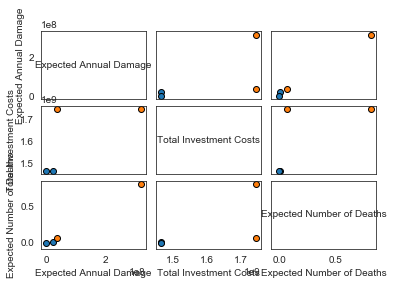

In [19]:
from ema_workbench.analysis import pairs_plotting
fig, axes = pairs_plotting.pairs_scatter(experiments=experiments, outcomes=outcomes, group_by='policy',
                                         legend=False)
plt.show()

# Global SA using SOBOL

In [20]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol
import statsmodels.api as sm
from ema_workbench.analysis import feature_scoring

In [42]:
# Reproducing the uncertainties defined in the dike model
# It does not matter which problem formulation id is used here, since the uncertainties are the same in every PF

uncertainties = []
for unc in model.uncertainties:
    uncertainties.append(unc)

# Transferring the uncertainties to the desired SALib problem format
problem = get_SALib_problem(uncertainties)

In [70]:
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 132), (30, 350), (0, 2), (0, 1), (30, 350), (0, 2), (0, 1), (30, 350), (0, 2), (0, 1), (30, 350), (0, 2), (0, 1), (30, 350), (0, 2), (0, 1), (0, 3), (0, 3), (0, 3)]}


In [100]:
n_exp = 10

with MultiprocessingEvaluator(model) as evaluator:
    experiments_sobol, outcomes_sobol = evaluator.perform_experiments(scenarios=n_exp,
                                                        uncertainty_sampling=SOBOL)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 400 scenarios * 1 policies * 1 model(s) = 400 experiments
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [101]:
EAD_final_sobol = outcomes_sobol['Expected Annual Damage']
EAD_mean_sobol = np.mean(outcomes_sobol['Expected Annual Damage'])
EAD_std_sobol = np.std(outcomes_sobol['Expected Annual Damage'])

In [102]:
Si = sobol.analyze(problem, EAD_final_sobol, calc_second_order=True, print_to_console=False)

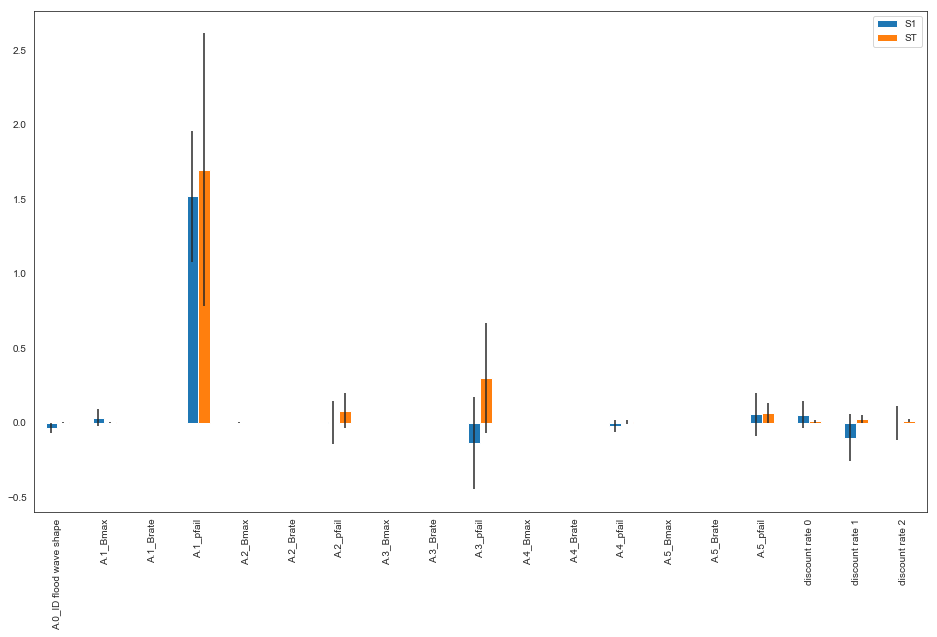

In [103]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(16,12)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [104]:
# We can also study the convergence of the Sobol indices as a function of the number of samples,
# by computing the indices over a partial sample:

Y = EAD_final_sobol

s_data = pd.DataFrame(index=problem['names'],
                      columns=np.arange(2,n_exp,5)*(2*problem['num_vars']+2))
for j in s_data.columns:
    scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
    s_data.loc[:,j] = scores['ST']

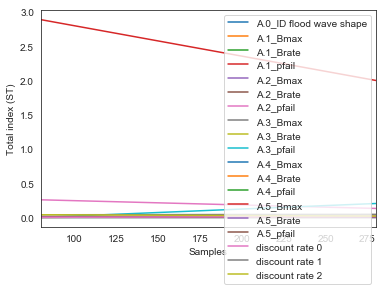

In [105]:
fig, ax = plt.subplots(1)

s_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
plt.show()

In [107]:
outcomes

{'Expected Annual Damage': array([2.34149023e+07, 0.00000000e+00, 3.19328884e+08, 3.85760398e+07]),
 'Total Investment Costs': array([1.46635761e+09, 1.46635570e+09, 1.74401773e+09, 1.74401773e+09]),
 'Expected Number of Deaths': array([0.00383069, 0.        , 0.81328588, 0.06742661])}